<a href="https://colab.research.google.com/github/FeryET/DeepLearning_CA7/blob/master/DL_CA7_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"
!kaggle datasets download -d adityajn105/flickr8k
!unzip -qo "/content/flickr8k.zip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)
--2021-06-03 12:44:29--  https://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... ^C
unzip:  cannot find or open glove.6B.zip, glove.6B.zip.zip or glove.6B.zip.ZIP.


In [ ]:
!pip install bcolz

In [ ]:
import bcolz
import numpy as np
from PIL import Image
import re
import string
from glob import glob
import pandas as pd
import string 
import itertools
import collections
import textwrap 
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import gensim.downloader as api


# Defining Constants

In [ ]:
# Locations
IMAGE_ROOT = "/content/Images"
CAPTION_CSV_LOC = "/content/captions.txt"


# Tokens
START_TOKEN = "<SOS>"
END_TOKEN = "<EOS>"
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

# Captions related
MAX_LENGTH = 30 
LSTM_HIDDEN_SIZE = 256 # LSTM units?
MIN_WORD_FREQ = 15
EMBEDDING_DIM = 100
CAPTIONS_PER_IMAGE = 5

MIN_WORD_LENGTH = 2


MAX_EPOCHS = 150

# Dataset specifice
TEST_SPLIT = 0.1

# Processing Documents

### Preprocessing Captions

In [ ]:
def preprocess_text(text):
  prep = text.lower()
  # remove whitespace, numerics and punctuations and replace them with space
  prep = re.sub("(\s+)|(\d+)|([^\w\s]+)", " ", prep)
  prep = prep.split()
  prep = [p for p in prep if len(p) >= MIN_WORD_LENGTH]
  return prep

# preprocess_text = lambda x: preprocess_string(x, filters=[
#                                                           strip_tags,
#                                                           strip_multiple_whitespaces,
#                                                           strip_punctuation,
#                                                           strip_numeric,
#                                                           lambda s: strip_short(s, minsize=2),
#                                                           stem_text])

caption_df = pd.read_csv(CAPTION_CSV_LOC)
caption_df.sort_values(by="image", inplace=True)
caption_df["cleaned"] = caption_df["caption"].apply(preprocess_text)

### Creating Vocabulary

In [ ]:
counter = collections.Counter(itertools.chain(*caption_df["cleaned"]))
words = sorted([v for v, n in counter.items() if n > MIN_WORD_FREQ])
words = [PAD_TOKEN, START_TOKEN, END_TOKEN, UNK_TOKEN] + words
vocab = {w: idx for idx, w in enumerate(words)}
id2word = {idx: w for idx, w in enumerate(words)}
print(f"Vocabulary Length: {len(vocab)}")

Vocabulary Length: 1493


### Creating Wordvectors

In [ ]:
w2v_model = api.load(f"glove-twitter-{EMBEDDING_DIM}")
embedding_weights = []
for k, v in vocab.items():
  try:
    w = w2v_model.wv[k]
  except Exception as e:
    # If the word is not in vocabulary of word2vec model
    w = np.random.normal(0, scale=1/EMBEDDING_DIM, size=(EMBEDDING_DIM,)).astype(np.float64)
  embedding_weights.append(w)
embedding_weights = np.array(embedding_weights)
print(embedding_weights.shape)

(1493, 100)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


### Defining Transforms for Captions

In [ ]:
class VocabTransform:
  def __init__(self, vocab):
    self.vocab = vocab
  
  def __call__(self, tokenized):
    return [self.vocab[t] if t in self.vocab.keys() else self.vocab[UNK_TOKEN] for t in tokenized]

class CaptionConditioner:
  def __init__(self, max_length=MAX_LENGTH):
    self.max_length = max_length
  
  def __call__(self, tokenized):
    return [START_TOKEN] + tokenized[:self.max_length - 2] + [END_TOKEN]

class TextIndicesToTensor:
  def __call__(self, item):
    return torch.tensor(tuple(item), dtype=torch.int64)



caption_transforms = transforms.Compose(
    [
     CaptionConditioner(),
     VocabTransform(vocab),
     TextIndicesToTensor(),
    ]
)

### Images

In [ ]:
# This is copied from https://pytorch.org/hub/pytorch_vision_resnet/
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224), # As an augmenting process
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std),
])

image_mean = np.array(image_mean)
image_std = np.array(image_std)

# Defining the Dataset

In [ ]:
class FlickrDataset(Dataset):
  def __init__(self, 
               images_path, 
               caption_df, 
               image_transforms, 
               caption_transforms,
               captions_per_image=CAPTIONS_PER_IMAGE):
    self.image_transforms = image_transforms
    self.caption_transforms = caption_transforms
    self.images_path = images_path
    self.images_fnames = sorted(os.listdir(images_path))
    self.df = caption_df
    self.captions_per_image = captions_per_image
    self.test_time = False

  def __len__(self):
    return len(self.images_fnames)

  def __getitem__(self, idx):
    fname = self.images_fnames[idx]
    fpath = os.path.join(self.images_path, fname)
    image = Image.open(fpath)
    
    idx *= self.captions_per_image # num of repeats
    if self.test_time:
      captions = list(self.df.iloc[idx:idx+self.captions_per_image]["caption"])
    else:
      captions = list(self.df.iloc[idx:idx+self.captions_per_image]["cleaned"])
      # transform only in test time
      image = self.image_transforms(image)
      captions = [self.caption_transforms(c) for c in captions]

    return image, captions


In [ ]:

# Influenced by https://github.com/siddsrivastava/Image-captioning/blob/master/model.py

class FlickrEncoderCNN(nn.Module):
  def __init__(self, 
               embedding_dim, 
               freeze):
    super().__init__()
    # Loading resnet
    resnet = torchvision.models.resnet18(pretrained=True)
    fc_in_features = resnet.fc.in_features

    # Defining layers
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.fc = nn.Linear(fc_in_features, embedding_dim)

    # Freezing if needed
    for param in self.resnet.parameters():
        param.requires_grad = False if freeze else True
    for param in self.fc.parameters():
      param.requires_grad = True
    
    self.modules = nn.ModuleList(
        [self.resnet, self.fc]
    )  
  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x


class FlickrDecoderLSTM(nn.Module):
  def __init__(self, 
                vocab_size,
                embedding_dim,
                hidden_size,
                padding_idx,
                bidirectional=False,
                dropout=0):
    
    super().__init__()
    # Creating embeddings
    # self.embed = nn.Embedding(num_embeddings=vocab_size,
    #                           embedding_dim=embedding_dim, 
    #                           padding_idx=padding_idx,
    #                           sparse=False,
    #                           )
    self.embed = nn.Embedding.from_pretrained(
        torch.FloatTensor(embedding_weights))

    self.lstm = nn.LSTM(input_size=embedding_dim,
                        hidden_size=hidden_size,
                        batch_first=True,
                        dropout=dropout,
                        bidirectional=bidirectional)
    

    self.fc = nn.Linear(hidden_size,vocab_size)

    self.modules = nn.ModuleList(
        [self.embed, self.lstm, self.fc]
    )

  def forward(self, features, caption_seqs, hidden=None):
      caption_seqs = caption_seqs[:,:-1] 
      embeddings = self.embed(caption_seqs)
      total_input = torch.cat((features.unsqueeze(1), embeddings), 1)
      lstm_out, hidden = self.lstm(total_input, hidden)
      outputs = self.fc(lstm_out)
      return outputs, hidden


class FlickrNet(nn.Module):
  def __init__(self, 
               vocab_size,
               embedding_dim,
               hidden_size,
               padding_idx,
               start_token_index,
               end_token_index,
               unk_token_index,
               bidirectional=False,
               dropout=0,
               freeze=True):
    super().__init__()
    self.vocab_size = vocab_size
    encoder = FlickrEncoderCNN(embedding_dim, freeze)
    decoder = FlickrDecoderLSTM(vocab_size, 
                                    embedding_dim, 
                                    hidden_size, 
                                    padding_idx, 
                                    bidirectional, 
                                    dropout)
    self.encoder = encoder
    self.decoder = decoder
    self.modules = nn.ModuleList([encoder,decoder])
    self.start_token_index = start_token_index
    self.end_token_index = end_token_index
    self.unk_token_index = unk_token_index

  def forward(self, images, caption_seqs):
    features = self.encoder(images)
    outputs, hiddens = self.decoder(features, caption_seqs)
    return outputs
  
  def predict(self, image, max_len = 30):
    with torch.no_grad():
        outputs = []
        hidden_size = self.decoder.lstm.hidden_size
        hidden = None
        # Needs to be turned into 1 x Channels x Width x Height
        features = self.encoder(image)
        inputs = features.unsqueeze(0)
        for idx in range(max_len):
          # lstm_out, hidden = self.decoder.lstm(inputs,hidden)
          lstm_out, hidden = self.decoder.lstm(inputs, hidden)
          output_vocab = self.decoder.fc(lstm_out)
          output_vocab = F.softmax(output_vocab.squeeze(1),dim=-1)
          output_word = torch.argsort(output_vocab, dim=-1, descending=True).squeeze()
          for j in range(len(output_word)):
            word = output_word[j].item()
            if word != self.unk_token_index:
              output_word = output_word[j]
              break
          outputs.append(word)
          if self.end_token_index == word:
            break
          inputs = self.decoder.embed(output_word.unsqueeze(0)).unsqueeze(0)
    return outputs

In [ ]:
# This is needed for batches

class RepeatImages:
  def __init__(self, num_repeat=CAPTIONS_PER_IMAGE):
    self.num_repeat = num_repeat

  def __call__(self, batch):
    result = []
    for image, captions in batch:
      for i in range(self.num_repeat):
        result.append((image, captions[i]))
    return result

class PadCaptions:
  def __init__(self, vocab):
    self.pad_idx = vocab[PAD_TOKEN]
  
  def __call__(self, batch):
    captions = []
    images = []
    for im, cap in batch:
      captions.append(cap)
      images.append(im.unsqueeze(0))
    captions = torch.nn.utils.rnn.pad_sequence(captions,
                                    batch_first=True,
                                    padding_value=self.pad_idx)
    images = torch.cat(images, dim=0)
    return images, captions


batch_transforms = transforms.Compose([
     RepeatImages(),
     PadCaptions(vocab),
     ]
)

# Preparing for Training

### Defining training and testing functions

In [ ]:
def generate_sentence(model):
    i = int(np.random.randint(0, len(test_dataset)))
    image, captions = test_dataset[i]
    image = image.unsqueeze(0).cuda()
    gen = model.predict(image)
    gen = " ".join([id2word[g] for g in gen])
    caption = " ".join([id2word[c] for c in captions[0].numpy()])
    print("#########################")
    print(f"### Original: {caption}")
    print(f"### Generated: {gen}")
    print("#########################")
    
def test(model, loss_function, test_loader):
  test_loss = 0
  n_items = 0
  with torch.no_grad():
    for batch in test_loader:
        images, captions = batch
        images, captions = images.cuda(), captions.cuda()

        outputs = model(images, captions)
        outputs = torch.moveaxis(outputs, -1, 1)
        loss = loss_function(outputs, captions)
      
        test_loss += loss.item() * captions.numel()
        n_items += captions.numel()
        
  test_loss /= n_items
  return test_loss

def train(model, optimizer, loss_function, train_loader, test_loader, model_name, max_epochs=50):
  scaler = torch.cuda.amp.GradScaler()
  info = []
  for epoch in range(1, max_epochs+1):
    train_loss = 0
    n_items = 0
    pbar = tqdm(total=len(train_loader), desc=f"Epoch: {epoch}", leave=False)
    for batch in train_loader:
      torch.cuda.empty_cache() 
      optimizer.zero_grad()

      images, captions = batch
      images, captions = images.cuda(), captions.cuda()
      
      with torch.cuda.amp.autocast():
        outputs = model(images, captions)
        outputs = torch.moveaxis(outputs, -1, 1)
        loss = loss_function(outputs, captions)

      # scaling the loss
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      
      # computing the running loss
      train_loss += loss.item() * captions.numel()
      n_items += captions.numel()

      # updating the progress bar
      pbar.set_postfix(batch_loss=f"{loss.item():.3f}")
      pbar.update()  

    pbar.close()
    train_loss /= n_items
    test_loss = test(model, loss_function, test_loader)
    info.append(
        {"epoch": epoch, "train_loss": train_loss, "val_loss": test_loss}
    )
    print(f"Epoch: {epoch}\t Train Loss: {train_loss:.3f}\t Test Loss: {test_loss:.3f}")
    if epoch % 10 == 0:
      torch.save(model, f"/content/drive/MyDrive/Academics/Courses/Deep Learning/CA3/Q1/{model_name}.model")
    if epoch % 5 == 0:
      generate_sentence(model)
    with open(f"/content/drive/MyDrive/Academics/Courses/Deep Learning/CA3/Q1/{model_name}.json", "w") as jfile:
      json.dump(info, jfile)
    
    # Start after 25th Epoch
    stop = True if len(info) > 25 else False
    # Early stopping
    for item in info[-5:]:
      # Stop if there's one loss in the last 5th that is bigger than your current one
      if item["train_loss"] - train_loss > 10e-3:
        stop = False
    if stop:
      break
  return info


### Defining Visualization Methods

In [ ]:
def visualize_model(model, folder, info):
  dataset.test_time = True
  for idx in test_indices:
    image, captions = test_dataset[idx]
    lengths = [len(preprocess_text(c)) for c in captions]
    image = np.array(image)
    input = np.moveaxis(image, -1, 0)
    input = torch.tensor(input, requires_grad=False, dtype=torch.float).cuda()
    # Maximum length of prediction should be between min and max!
    max_length=(max(lengths) + min(lengths))//2
    pred = model.predict(input.unsqueeze(0), max_len=max_length)
    
    h, w, c = image.shape
    aspect = w / h
    eps = 0.05
    figsize = (12, 5)
    fig, axes = plt.subplots(1,2,figsize=figsize, gridspec_kw={"height_ratios": [1], 
                                                               "width_ratios":  [1, 1]})
    # Showing text
    ax = axes[0]
    ax.axis('off')
    words = [id2word[p] for p in pred]
    pred_sentence = "Predicted:\n" + " ".join(
        [w for w in words if w not in [UNK_TOKEN, PAD_TOKEN, START_TOKEN, END_TOKEN]]
        )
    originals = "Original Captions:\n" + "\n\n".join([f"{idx+1}. {c}" for idx, c in enumerate(captions)])
    text = pred_sentence + "\n\n" + originals
    wrapper = textwrap.TextWrapper(width=70, 
                                   replace_whitespace=True, 
                                   drop_whitespace=True,
                                   tabsize=4, expand_tabs=False, 
                                   fix_sentence_endings=True)
    text = "\n".join([wrapper.fill(t) for t in text.splitlines()])
    t = ax.text(0, 0.5, text,
      horizontalalignment='left',
      verticalalignment='center',
      transform = ax.transAxes,
      wrap=True)

    # Showing Image
    ax = axes[1]
    ax.axis('off')
    ax.imshow(image)

    plt.savefig(os.path.join(folder, f"{idx+1}.png"))

  # It's important to revert the dataset back to where it was
  dataset.test_time = False

  info_df = pd.DataFrame(info)
  fig, ax = plt.subplots(figsize=(7,7))

  ax.plot(info_df["train_loss"], c="seagreen", label="Train Loss")
  ax.plot(info_df["val_loss"], c="firebrick", label="Val Loss")
  ax.legend()
  plt.savefig(os.path.join(folder, f"train_val_loss.png"))
  

### Creating Dataset and DataLoader

In [ ]:
dataset = FlickrDataset(
    images_path=IMAGE_ROOT, 
    caption_df=caption_df,
    image_transforms=image_transforms, 
    caption_transforms=caption_transforms,
)
test_length = int(TEST_SPLIT * len(dataset))
train_length = len(dataset) - test_length
train_dataset, test_dataset = random_split(dataset, 
                                           [train_length, test_length], 
                                           generator=torch.Generator(device="cpu").manual_seed(42))

In [ ]:
train_batch_size = 128
test_batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, collate_fn=batch_transforms, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, collate_fn=batch_transforms, shuffle=True)

# Creating models and training

## Part A

In [ ]:
model = FlickrNet(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_size=LSTM_HIDDEN_SIZE,
    padding_idx=vocab[PAD_TOKEN],
    start_token_index=vocab[START_TOKEN],
    end_token_index=vocab[END_TOKEN],           
    unk_token_index=vocab[UNK_TOKEN],
    bidirectional=False,
    dropout=0,
    freeze=True
    ).cuda()

loss_function = nn.CrossEntropyLoss(reduction='mean').cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=10e-3,weight_decay=10e-3)

In [ ]:
# Set the tqdm text color to white.

from IPython.display import HTML, display

def set_css_in_cell_output():
    display(HTML('''
        <style>
            .jupyter-widgets {color: #d5d5d5 !important;}
            .widget-label {color: #d5d5d5 !important;}
        </style>
    '''))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

In [ ]:
part_a_info = train(model, optimizer, loss_function, train_loader, test_loader, "part_a",max_epochs=MAX_EPOCHS)

Epoch: 1	 Train Loss: 2.154	 Test Loss: 1.581


Epoch: 2	 Train Loss: 1.504	 Test Loss: 1.382


Epoch: 3	 Train Loss: 1.389	 Test Loss: 1.367


Epoch: 4	 Train Loss: 1.321	 Test Loss: 1.307


Epoch: 5	 Train Loss: 1.292	 Test Loss: 1.257
#########################
### Original: <SOS> child pushes its face up towards window of playground <EOS>
### Generated: <SOS> two people are sitting on the edge of cliff <EOS>
#########################


Epoch: 6	 Train Loss: 1.241	 Test Loss: 1.266


Epoch: 7	 Train Loss: 1.206	 Test Loss: 1.246


Epoch: 8	 Train Loss: 1.183	 Test Loss: 1.271


Epoch: 9	 Train Loss: 1.163	 Test Loss: 1.252


Epoch: 10	 Train Loss: 1.142	 Test Loss: 1.227
#########################
### Original: <SOS> little girl throwing food in the air for her white dog to catch <EOS>
### Generated: <SOS> two people are standing on the beach <EOS>
#########################



### Plot Part A

In [ ]:
np.random.seed(92)
test_indices = np.random.choice(np.arange(len(test_dataset)), size=(3,))

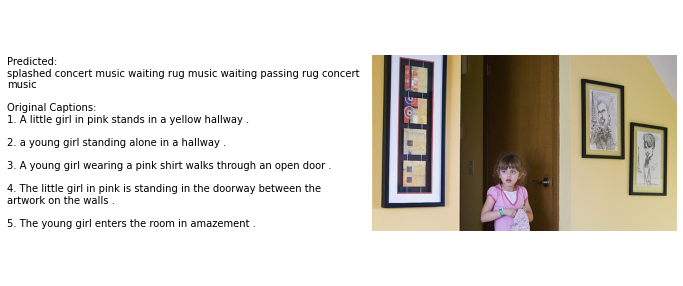

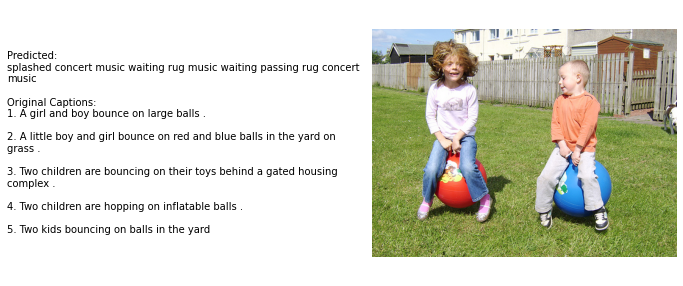

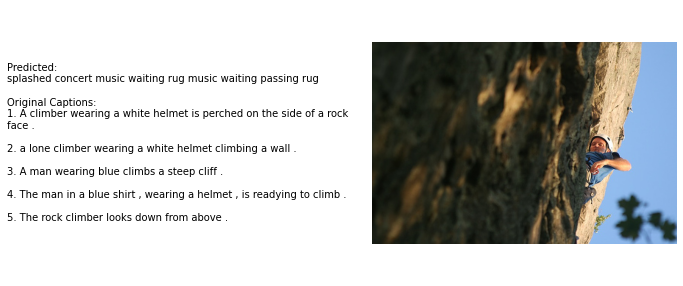

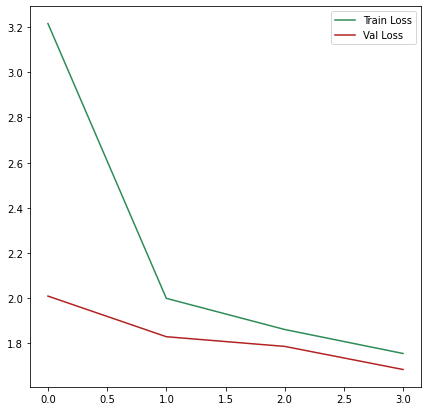

In [ ]:
with open("/content/drive/MyDrive/Academics/Courses/Deep Learning/CA3/Q1/part_a.json") as jfile:
  part_a_info = json.load(jfile)
part_a_path = "part_a_result"
if not os.path.isdir(part_a_path):
  os.mkdir(part_a_path)

visualize_model(model, part_a_path, part_a_info)

## Train Part B

In this part we unfreeze the resnet layers

In [ ]:
model = FlickrNet(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_size=LSTM_HIDDEN_SIZE,
    padding_idx=vocab[PAD_TOKEN],
    start_token_index=vocab[START_TOKEN],
    end_token_index=vocab[END_TOKEN],           
    unk_token_index=vocab[UNK_TOKEN],
    bidirectional=False,
    dropout=0,
    freeze=False,
    ).cuda()

loss_function = nn.CrossEntropyLoss(reduction='mean').cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-5,weight_decay=10e-3)

torch.cuda.empty_cache()

In [ ]:
part_b_info = train(model, optimizer, loss_function, train_loader, test_loader, "part_b", max_epochs=MAX_EPOCHS)

In [ ]:
part_b_path = "part_b_result"
if not os.path.isdir(part_b_path):
  os.mkdir(part_b_path)

visualize_model(model, part_b_path, part_b_info)

### Part C

In this part we use a bidirectional LSTM but with Freezing

In [ ]:
model = FlickrNet(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_size=LSTM_HIDDEN_SIZE,
    padding_idx=vocab[PAD_TOKEN],
    start_token_index=vocab[START_TOKEN],
    end_token_index=vocab[END_TOKEN],           
    unk_token_index=vocab[UNK_TOKEN],
    bidirectional=False,
    dropout=0,
    freeze=True,
    ).cuda()

loss_function = nn.CrossEntropyLoss(reduction='mean').cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-4,weight_decay=10e-3)

torch.cuda.empty_cache()

In [ ]:
part_c_info = train(model, optimizer, loss_function, train_loader, test_loader, "part_c", max_epochs=MAX_EPOCHS)

In [ ]:
part_c_path = "part_c_result"
if not os.path.isdir(part_c_path):
  os.mkdir(part_c_path)

visualize_model(model, part_c_path, part_c_info)

### Part D

In this part we use a bidirectional LSTM but without freezing resnet layers

In [ ]:
model = FlickrNet(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_size=LSTM_HIDDEN_SIZE,
    padding_idx=vocab[PAD_TOKEN],
    start_token_index=vocab[START_TOKEN],
    end_token_index=vocab[END_TOKEN],           
    unk_token_index=vocab[UNK_TOKEN],
    bidirectional=False,
    dropout=0,
    freeze=False,
    ).cuda()

loss_function = nn.CrossEntropyLoss(reduction='mean').cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-5,weight_decay=10e-3)

torch.cuda.empty_cache()

In [ ]:
part_d_info = train(model, optimizer, loss_function, train_loader, test_loader, "part_d", max_epochs=MAX_EPOCHS)

In [ ]:
part_d_path = "part_d_result"
if not os.path.isdir(part_d_path):
  os.mkdir(part_d_path)

visualize_model(model, part_d_path, part_d_info)